# Smart San Antonio

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# Geospatial Library
import folium
import folium.plugins as plugins

import src

sns.set_context('talk')
plt.style.use('tableau-colorblind10')

## Acquire

In [2]:
df = src.get_zone_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125133 entries, 0 to 125132
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DateTime        125133 non-null  object 
 1   Sensor_id       125133 non-null  object 
 2   Vendor          125133 non-null  object 
 3   SensorModel     125133 non-null  object 
 4   LAT             125133 non-null  float64
 5   LONG            125133 non-null  float64
 6   Zone            125133 non-null  object 
 7   NoiseLevel_db   125133 non-null  int64  
 8   AlertTriggered  91725 non-null   object 
 9   SensorStatus    125133 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 9.5+ MB


In [4]:
df.head(3)

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
0,2021-05-20T00:01:27,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal
1,2021-05-20T00:04:27,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal
2,2021-05-20T00:07:28,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal


In [5]:
df.tail(3)

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
125130,2021-05-29T23:45:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal
125131,2021-05-29T23:50:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal
125132,2021-05-29T23:55:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal


In [6]:
df.isna().sum()

DateTime              0
Sensor_id             0
Vendor                0
SensorModel           0
LAT                   0
LONG                  0
Zone                  0
NoiseLevel_db         0
AlertTriggered    33408
SensorStatus          0
dtype: int64

In [7]:
df.nunique()

DateTime          41140
Sensor_id            13
Vendor                2
SensorModel           2
LAT                  19
LONG                 19
Zone                  5
NoiseLevel_db        62
AlertTriggered        1
SensorStatus          1
dtype: int64

In [8]:
df.describe()

,LAT,LONG,NoiseLevel_db
count,125133.000000,125133.000000,125133.000000
mean,29.423296,-98.499431,60.744368
std,0.065049,0.058557,11.592717
min,29.341590,-98.583610,30.000000
25%,29.345660,-98.580288,56.000000
50%,29.416610,-98.483660,63.000000
75%,29.507520,-98.439560,68.000000
max,29.510070,-98.434544,194.000000


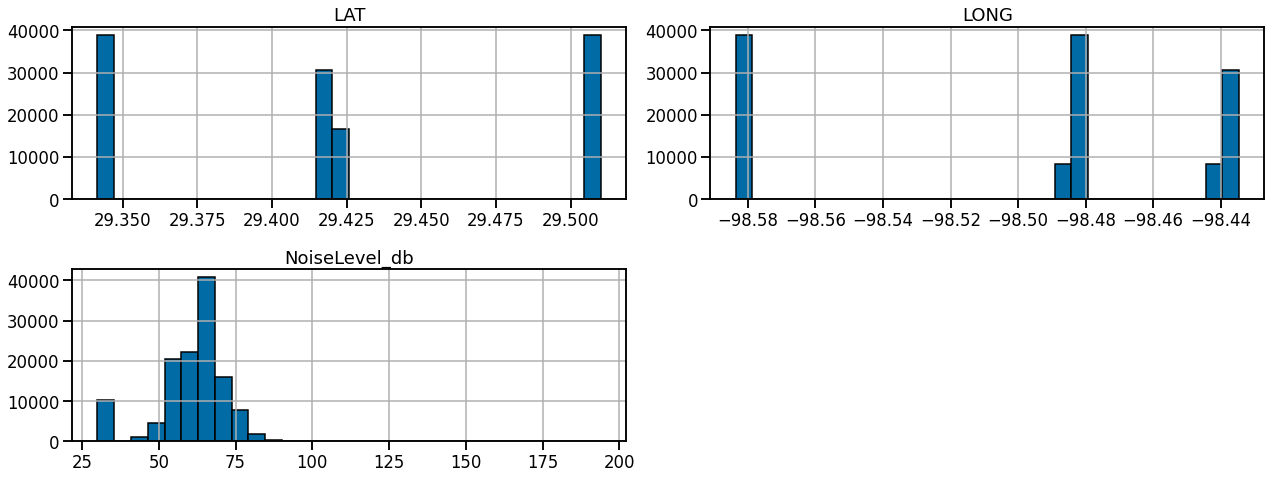

In [9]:
sns.set_context('talk')
plt.style.use('tableau-colorblind10')

df.hist(figsize=(18, 7), bins=30, ec='black')
plt.tight_layout();

## Prepare

- Format column names
- Replace column names with descriptive names
- Cast the date strings as datetime.
- Replace missing values in the `alert_triggered` column with "Not Supported".
    - Refer to the data dictionary.
- Replace "Downtown Market XX" zone with "Downtown"

In [10]:
df = src.prep_sensor_data(df)

In [11]:
# Replace duplicate sensor id's lat and long with the most recent lat and long positions.
id_duplicates = ['64d7e0e4cfeba0b6', '64d7e4dbde37ccb5']

df.loc[df.sensor_id == '64d7e0e4cfeba0b6', ('latitude', 'longitude')] = (29.41486, -98.481488)
df.loc[df.sensor_id == '64d7e4dbde37ccb5', ('latitude', 'longitude')] = (29.41591, -98.482880)

## Explore

## How many noise sensors were placed in each zone for the pilot program?

In [12]:
df.groupby('zone').sensor_id.nunique()

zone
Brooks            4
Downtown          5
Medical Center    4
Name: sensor_id, dtype: int64

## Where are the Noise Sensors located?

In [13]:
geo_cols = ['zone', 'sensor_id', 'latitude', 'longitude']
df_sensors = df.groupby(geo_cols)['date'].max().reset_index()
df_sensors

,zone,sensor_id,latitude,longitude,date
0,Brooks,63554,29.34159,-98.439560,2021-05-29 23:55:00
1,Brooks,63d684c940ce1f6b,29.34566,-98.434544,2021-05-29 23:58:36
2,Brooks,689324d0f345350d,29.34473,-98.435672,2021-05-29 23:58:36
3,Brooks,6de2cc6034fd26e8,29.34412,-98.436440,2021-05-29 23:58:36
4,Downtown,63540,29.42288,-98.486930,2021-05-29 23:55:00
5,Downtown,63547,29.42210,-98.483660,2021-05-29 23:55:00
6,Downtown,63db58629a2d20a7,29.41661,-98.484080,2021-05-29 23:58:36
7,Downtown,64d7e0e4cfeba0b6,29.41486,-98.481488,2021-05-29 23:58:36
8,Downtown,64d7e4dbde37ccb5,29.41591,-98.482880,2021-05-29 23:58:36
9,Medical Center,63568,29.50930,-98.583610,2021-05-29 23:55:00


In [17]:
m = folium.Map(location=[29.4363, -98.4881],
               zoom_start=10,
               max_bounds=True,
            zoom_control=False)

# Plot the coordinates for each noise sensor.

zone_colors = ['orange', 'red', 'purple']
zones = ['Brooks', 'Downtown', 'Medical Center']

for z, zc in zip(zones, zone_colors):
    data = df_sensors[df_sensors.zone == z]

    for _, row in data.iterrows():
        m.add_child(
            folium.Marker(location=[str(row['latitude']), str(row['longitude'])],
                          tooltip=row['zone'],
                          prefer_canvas=True,
                          disable_3d=True,
                          icon=folium.Icon(icon='volume-up',
                                           color=zc,
                                           prefix='fa')
                         )
                    )

In [19]:
m

## What is the loudest noise recorded in each zone? 

In [16]:
df.groupby('zone').noise_level.agg(['min', 'max', 'mean'])

,min,max,mean
zone,,,
Brooks,30,194,59.755453
Downtown,30,191,58.562923
Medical Center,49,111,64.382681


### Hypothesis Tests

## Conclusions 